<a href="https://colab.research.google.com/github/hessandrea/PlanetScope_DataCrunch/blob/master/PlanetScope_ToaReflectance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install rasterio
import rasterio
import numpy as np
import os

In [40]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
folders = os.listdir ("/content/drive/My Drive/PlanetScope")
folders[0]




'283030_3744107_2016-11-02_0e26'

In [42]:
if len("/content/drive/My Drive/PlanetScope") > 1:
    SearchDirectory = "/content/drive/My Drive/PlanetScope"
    print("I'm looking for tifs in ", SearchDirectory)
else:
    print("Please tell me the directory to look in")
    sys.exit()





I'm looking for tifs in  /content/drive/My Drive/PlanetScope


In [43]:
SearchDirectory = "/content/drive/My Drive/PlanetScope"

for root, dirs, files in os.walk(SearchDirectory):
     print("                  new iteration")
     image_files = []
     for file in files:
         #if file.endswith(("BGRN_Analytic.tif")):
         if ((os.path.basename(root)).startswith("2")) or (os.path.basename(root)).startswith("3")  and (file.endswith("BGRN_Analytic.tif")):
             print("Discovered this tif: ", os.path.join(root, file))
             image_files.append(os.path.join(root, file))

     if image_files:
         filedirectory =  root+ "/" + root[-30:]
         filename =  filedirectory  + "_BGRN_Analytic.tif"
         print("using tif file: ", filename)
         xmlfile =  filedirectory  + "_BGRN_Analytic_metadata.xml"
         print("using meta file: ", xmlfile)
         output_file =  filedirectory + "_refl.tif"
         print ("calculating TOA and saving it into ", output_file)
         #pdf_bytes = img2pdf.convert(image_files)
         #file = open(output_file,"wb")
         #file.write(pdf_bytes)

         # Load red and NIR bands - note all PlanetScope 4-band images have band order BGRN
         with rasterio.open(filename) as src:
             band_blue_radiance = src.read(1)
            
         with rasterio.open(filename) as src:
             band_green_radiance = src.read(2)

         with rasterio.open(filename) as src:
             band_red_radiance = src.read(3)

         with rasterio.open(filename) as src:
             band_nir_radiance = src.read(4)

         from xml.dom import minidom

         xmldoc = minidom.parse(xmlfile)
         nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")

         # XML parser refers to bands by numbers 1-4
         coeffs = {}
         for node in nodes:
             bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
             if bn in ['1', '2', '3', '4']:
                 i = int(bn)
                 value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
                 coeffs[i] = float(value)

         print ("Conversion coefficients:", coeffs)

         # Multiply the Digital Number (DN) values in each band by the TOA reflectance coefficients
         band_blue_reflectance = band_blue_radiance * coeffs[1]
         band_green_reflectance = band_green_radiance * coeffs[2]
         band_red_reflectance = band_red_radiance * coeffs[3]
         band_nir_reflectance = band_nir_radiance * coeffs[4]

         import numpy as np
         print ("Red band radiance is from {} to {}".format(np.amin(band_red_radiance), np.amax(band_red_radiance)))
         print ("Red band reflectance is from {} to {}".format(np.amin(band_red_reflectance), np.amax(band_red_reflectance)))

         kwargs = src.meta
         kwargs.update(
             dtype=rasterio.uint16,
             count = 4)

         print ("Before Scaling, red band reflectance is from {} to {}".format(np.amin(band_red_reflectance), np.amax(band_red_reflectance)))

         # Here we include a fixed scaling factor. This is common practice.
         scale = 10000
         blue_ref_scaled = scale * band_blue_reflectance
         green_ref_scaled = scale * band_green_reflectance
         red_ref_scaled = scale * band_red_reflectance
         nir_ref_scaled = scale * band_nir_reflectance

         print ("After Scaling, red band reflectance is from {} to {}".format(np.amin(red_ref_scaled), np.amax(red_ref_scaled)))

        # Write band calculations to a new raster file

         print("writing reflectance file to: ", output_file)

         with rasterio.open(output_file, 'w', **kwargs) as dst:
                 dst.write_band(1, blue_ref_scaled.astype(rasterio.uint16))
                 dst.write_band(2, green_ref_scaled.astype(rasterio.uint16))
                 dst.write_band(3, red_ref_scaled.astype(rasterio.uint16))
                 dst.write_band(4, nir_ref_scaled.astype(rasterio.uint16))

    #print(dst)
     else:
         print ("Couldn't find any tifs")

                  new iteration
Couldn't find any tifs
                  new iteration
Discovered this tif:  /content/drive/My Drive/PlanetScope/283030_3744107_2016-11-02_0e26/283030_3744107_2016-11-02_0e26_BGRN_Analytic.tif
Discovered this tif:  /content/drive/My Drive/PlanetScope/283030_3744107_2016-11-02_0e26/283030_3744107_2016-11-02_0e26_BGRN_Analytic_metadata.xml
Discovered this tif:  /content/drive/My Drive/PlanetScope/283030_3744107_2016-11-02_0e26/283030_3744107_2016-11-02_0e26_BGRN_DN_udm.tif
Discovered this tif:  /content/drive/My Drive/PlanetScope/283030_3744107_2016-11-02_0e26/283030_3744107_2016-11-02_0e26_metadata.json
Discovered this tif:  /content/drive/My Drive/PlanetScope/283030_3744107_2016-11-02_0e26/283030_3744107_2016-11-02_0e26_refl.tif
using tif file:  /content/drive/My Drive/PlanetScope/283030_3744107_2016-11-02_0e26/283030_3744107_2016-11-02_0e26_BGRN_Analytic.tif
using meta file:  /content/drive/My Drive/PlanetScope/283030_3744107_2016-11-02_0e26/283030_3744

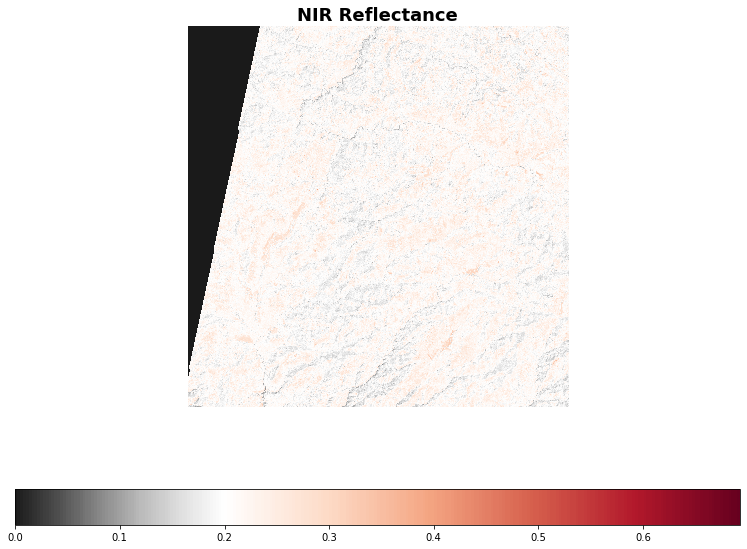

In [38]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

"""
The reflectance values will range from 0 to 1. You want to use a diverging color scheme to visualize the data,
and you want to center the colorbar at a defined midpoint. The class below allows you to normalize the colorbar.
"""

class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    Credit: Joe Kington, http://chris35wills.github.io/matplotlib_diverging_colorbar/
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))


# Set min/max values from reflectance range for image (excluding NAN)
min=np.nanmin(band_nir_reflectance)
max=np.nanmax(band_nir_reflectance)
mid=0.20

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

# diverging color scheme chosen from https://matplotlib.org/users/colormaps.html
# note that appending '_r' to the color scheme name reverses it!
cmap = plt.cm.get_cmap('RdGy_r')

cax = ax.imshow(band_nir_reflectance, cmap=cmap, clim=(min, max), norm=MidpointNormalize(midpoint=mid,vmin=min, vmax=max))

ax.axis('off')
ax.set_title('NIR Reflectance', fontsize=18, fontweight='bold')

cbar = fig.colorbar(cax, orientation='horizontal', shrink=0.65)

#fig.savefig("data/ref-fig.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

plt.show()
